<a href="https://colab.research.google.com/github/Lubaszka/Lubaszka/blob/main/Spark_Lab_Dataframes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark setup

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz > /dev/null
!pip install -q findspark > /dev/null
!pip install seaborn networkx > /dev/null

In [ ]:
#import os

#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
#os.environ["JAVA_HOME"] = ""
#os.environ["SPARK_HOME"] = ""

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Spark_lab").getOrCreate()
spark

In [ ]:
spark = SparkSession.builder \
    .appName("Air flights Data Analysis") \
    .master('local[*]') \
    .getOrCreate()
spark

# Exploring data sets

*Source: https://www.kaggle.com/datasets/elmoallistair/airlines-airport-and-routes*

**Note**: this downloads files locally which works for small files, but normally data would be read by distributed workers in parallel from a distributed (e.g. HDFS) or object (e.g. S3) storage

In [ ]:
!wget https://raw.githubusercontent.com/dice-dydakt/datasets/main/routes.csv
!wget https://raw.githubusercontent.com/dice-dydakt/datasets/main/airports_all.csv -O airports.csv

--2025-03-06 18:49:48--  https://raw.githubusercontent.com/dice-dydakt/datasets/main/routes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2377264 (2.3M) [text/plain]
Saving to: ‘routes.csv’

routes.csv          100%[===================>]   2.27M  --.-KB/s    in 0.07s   

2025-03-06 18:49:49 (30.4 MB/s) - ‘routes.csv’ saved [2377264/2377264]

--2025-03-06 18:49:49--  https://raw.githubusercontent.com/dice-dydakt/datasets/main/airports_all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 754309 (737K) [text/plain]
Saving to

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, avg, count
from pyspark.sql import DataFrame

## Routes data set

In [ ]:
routes_df = spark.read.csv('routes.csv', header=True, inferSchema=True)
routes_df

DataFrame[Airline: string, Airline ID: string, Source Airport: string, Source Airport ID: string, Destination Airport: string, Destination Airport ID: string, Codeshare: string, Stops: int, Equipment: string]

In [ ]:
def rename_columns_lowercase_underscore(df: DataFrame) -> DataFrame:
    for col_name in df.columns:
        new_col_name = col_name.lower().replace(" ", "_")
        df = df.withColumnRenamed(col_name, new_col_name)
    return df

In [ ]:
routes_df = rename_columns_lowercase_underscore(routes_df)

In [ ]:
routes_df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- airline_id: string (nullable = true)
 |-- source_airport: string (nullable = true)
 |-- source_airport_id: string (nullable = true)
 |-- destination_airport: string (nullable = true)
 |-- destination_airport_id: string (nullable = true)
 |-- codeshare: string (nullable = true)
 |-- stops: integer (nullable = true)
 |-- equipment: string (nullable = true)



In [ ]:
routes_df.show(10)

+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+
|airline|airline_id|source_airport|source_airport_id|destination_airport|destination_airport_id|codeshare|stops|equipment|
+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+
|     2B|       410|           AER|             2965|                KZN|                  2990|     NULL|    0|      CR2|
|     2B|       410|           ASF|             2966|                KZN|                  2990|     NULL|    0|      CR2|
|     2B|       410|           ASF|             2966|                MRV|                  2962|     NULL|    0|      CR2|
|     2B|       410|           CEK|             2968|                KZN|                  2990|     NULL|    0|      CR2|
|     2B|       410|           CEK|             2968|                OVB|                  4078|     NULL|    0|      CR2|
|     2B|       

In [ ]:
routes_df.summary().show()

+-------+------------------+------------------+--------------+------------------+-------------------+----------------------+---------+--------------------+-----------------+
|summary|           airline|        airline_id|source_airport| source_airport_id|destination_airport|destination_airport_id|codeshare|               stops|        equipment|
+-------+------------------+------------------+--------------+------------------+-------------------+----------------------+---------+--------------------+-----------------+
|  count|             67663|             67663|         67663|             67663|              67663|                 67663|    14597|               67663|            67645|
|   mean| 6.546391752577319|3520.7360532269586|           NaN| 2693.690079029699|                NaN|    2695.7377598529106|     NULL|1.625703855873963...|514.0879972174793|
| stddev|1.4507226543799718| 3527.474762387847|           NaN|1672.3917978703216|                NaN|    1673.3067186069238|     N

Counting the most common routes

In [ ]:
# Count the most common routes
common_routes = routes_df.groupBy("source_airport", "destination_airport")\
.count()\
.orderBy(col("count").desc())

common_routes.show()

+--------------+-------------------+-----+
|source_airport|destination_airport|count|
+--------------+-------------------+-----+
|           ORD|                ATL|   20|
|           ATL|                ORD|   19|
|           HKT|                BKK|   13|
|           ORD|                MSY|   13|
|           JFK|                LHR|   12|
|           CAN|                HGH|   12|
|           MIA|                ATL|   12|
|           LHR|                JFK|   12|
|           ATL|                MIA|   12|
|           HKG|                BKK|   12|
|           DOH|                BAH|   12|
|           AUH|                MCT|   12|
|           BKK|                HKG|   12|
|           KGL|                EBB|   11|
|           MSY|                JFK|   11|
|           JFK|                CDG|   11|
|           ATL|                DEN|   11|
|           CDG|                JFK|   11|
|           JFK|                MSY|   11|
|           LAX|                LHR|   11|
+----------

Spark Dataframes API supports SQL like syntax to query data directly

In [ ]:
# Register routes as view to make it available for Spark SQL
routes_df.createOrReplaceTempView("routes")

In [ ]:
common_routes_sql = """
SELECT source_airport, destination_airport, COUNT(*) AS route_count
FROM routes
GROUP BY source_airport, destination_airport
ORDER BY route_count DESC
"""

common_routes = spark.sql(common_routes_sql)
common_routes.show()

+--------------+-------------------+-----------+
|source_airport|destination_airport|route_count|
+--------------+-------------------+-----------+
|           ORD|                ATL|         20|
|           ATL|                ORD|         19|
|           HKT|                BKK|         13|
|           ORD|                MSY|         13|
|           JFK|                LHR|         12|
|           CAN|                HGH|         12|
|           MIA|                ATL|         12|
|           LHR|                JFK|         12|
|           ATL|                MIA|         12|
|           HKG|                BKK|         12|
|           DOH|                BAH|         12|
|           AUH|                MCT|         12|
|           BKK|                HKG|         12|
|           KGL|                EBB|         11|
|           MSY|                JFK|         11|
|           JFK|                CDG|         11|
|           ATL|                DEN|         11|
|           CDG|    

Finding the most popular airport

Dataframe API supports also other SQL typical operatoions like **unions** and different **agg** types

**Assignment**: use the Gemini AI assistant to explain this query. Suggested prompt: "Illustrate how unionAll works in this query"

In [ ]:
most_connected_airports = routes_df\
.groupBy("source_airport")\
.count()\
.unionAll(
    routes_df.groupBy("destination_airport").count()
)\
.groupBy("source_airport")\
.agg({"count": "sum"})\
.orderBy(col("sum(count)").desc())

most_connected_airports.show()

+--------------+----------+
|source_airport|sum(count)|
+--------------+----------+
|           ATL|      1826|
|           ORD|      1108|
|           PEK|      1069|
|           LHR|      1051|
|           CDG|      1041|
|           FRA|       990|
|           LAX|       990|
|           DFW|       936|
|           JFK|       911|
|           AMS|       903|
|           PVG|       825|
|           SIN|       820|
|           BCN|       783|
|           ICN|       740|
|           DEN|       735|
|           MIA|       734|
|           MUC|       728|
|           IST|       719|
|           DXB|       710|
|           HKG|       710|
+--------------+----------+
only showing top 20 rows



## 2. Airports data set

In [ ]:
airports_df = spark.read.csv('airports.csv', header=True, inferSchema=True)
airports_df

DataFrame[Name: string, City: string, Country: string, IATA: string, ICAO: string, Latitude: double, Longitude: double, Altitude: int, Timezone8: string, DST: string, Timezone10: string]

In [ ]:
airports_df = rename_columns_lowercase_underscore(airports_df)

In [ ]:
airports_df.show()

+--------------------+--------------+----------------+----+----+------------+------------+--------+---------+---+--------------------+
|                name|          city|         country|iata|icao|    latitude|   longitude|altitude|timezone8|dst|          timezone10|
+--------------------+--------------+----------------+----+----+------------+------------+--------+---------+---+--------------------+
|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|-6.081689835| 145.3919983|    5282|       10|  U|Pacific/Port_Moresby|
|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|-5.207079887| 145.7890015|      20|       10|  U|Pacific/Port_Moresby|
|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789856| 144.2960052|    5388|       10|  U|Pacific/Port_Moresby|
|      Nadzab Airport|        Nadzab|Papua New Guinea| LAE|AYNZ|   -6.569803|  146.725977|     239|       10|  U|Pacific/Port_Moresby|
|Port Moresby Jack...|  Port Moresby|Papua New Guinea| 

In [ ]:
airports_df.select("city").distinct().show()
airports_df.select("city").distinct().count()

+--------------------+
|                city|
+--------------------+
|             Antwerp|
|           Magdeburg|
|               Mainz|
|            Sumburgh|
|               Jever|
|             Malanje|
|Hwange National Park|
|           Kisangani|
|            Hargeisa|
|                Ales|
|            Miquelon|
|        Thessaloniki|
|             Palermo|
|             Morelia|
|        Villahermosa|
|             Golfito|
|            Girardot|
|           Volgograd|
|           Samarkand|
|           Bangalore|
+--------------------+
only showing top 20 rows



6956

In [ ]:
airports_df.groupBy("country").count().orderBy(col("count").desc()).show(40)

+----------------+-----+
|         country|count|
+----------------+-----+
|   United States| 1512|
|          Canada|  430|
|       Australia|  334|
|          Russia|  264|
|          Brazil|  264|
|         Germany|  249|
|           China|  241|
|          France|  217|
|  United Kingdom|  167|
|           India|  148|
|       Indonesia|  145|
|           Japan|  123|
|    South Africa|   99|
|       Argentina|   96|
|          Mexico|   84|
|           Italy|   83|
|            Iran|   82|
|          Sweden|   77|
|          Turkey|   76|
|        Colombia|   75|
|     Philippines|   71|
|           Spain|   64|
|          Norway|   63|
|     New Zealand|   60|
|       Venezuela|   57|
|       Greenland|   56|
|          Greece|   55|
|        Pakistan|   54|
|         Finland|   51|
|        Thailand|   50|
|           Chile|   46|
|    Saudi Arabia|   45|
|         Algeria|   44|
|Congo (Kinshasa)|   44|
|French Polynesia|   44|
|           Burma|   43|
|      Madagascar|   43|


Find out which flights are domestic (inner country) and which are international.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when


# Join on source airport
routes_with_source_country = routes_df.join(
    airports_df,
    routes_df.source_airport == airports_df.iata,
    "left"
).select(routes_df["*"], col("country").alias("source_country"), col("city").alias("source_city"))

# Join again on destination airport
routes_with_countries = routes_with_source_country.join(
    airports_df,
    routes_with_source_country.destination_airport == airports_df.iata,
    "left"
).select(routes_with_source_country["*"], col("country").alias("dest_country"), col("city").alias("dest_city"))

# Add a column 'flight_type'
routes_with_flight_type = routes_with_countries.withColumn(
    "flight_type",
    when(col("source_country") == col("dest_country"), "Domestic")
    .otherwise("International")
)

flights_type_df = routes_with_flight_type.select("source_airport", "destination_airport", "source_city", "dest_city", "source_country", "dest_country", "flight_type")
flights_type_df.show()

+--------------+-------------------+-----------+---------------+--------------+------------+-------------+
|source_airport|destination_airport|source_city|      dest_city|source_country|dest_country|  flight_type|
+--------------+-------------------+-----------+---------------+--------------+------------+-------------+
|           AER|                KZN|      Sochi|          Kazan|        Russia|      Russia|     Domestic|
|           ASF|                KZN|  Astrakhan|          Kazan|        Russia|      Russia|     Domestic|
|           ASF|                MRV|  Astrakhan|Mineralnye Vody|        Russia|      Russia|     Domestic|
|           CEK|                KZN|Chelyabinsk|          Kazan|        Russia|      Russia|     Domestic|
|           CEK|                OVB|Chelyabinsk|    Novosibirsk|        Russia|      Russia|     Domestic|
|           DME|                KZN|     Moscow|          Kazan|        Russia|      Russia|     Domestic|
|           DME|                NBC| 

Plotting top international routes

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

int_routes_df = routes_with_flight_type\
.filter(routes_with_flight_type.flight_type == "International")\
.select("source_city", "dest_city")\
.groupBy("source_city", "dest_city").agg(count("*").alias("num_flights"))\
.orderBy(col("num_flights").desc()).limit(300)\
.filter(col("dest_city").isNotNull() & col("source_city").isNotNull()) # Filter out rows with missing values


int_routes_df.show()

+-----------------+-----------------+-----------+
|      source_city|        dest_city|num_flights|
+-----------------+-----------------+-----------+
|            Tokyo|            Seoul|         17|
|            Seoul|            Tokyo|         17|
|           London|Palma de Mallorca|         17|
|         Shanghai|           Taipei|         17|
|           Taipei|         Shanghai|         17|
|         New York|           London|         16|
|Palma de Mallorca|           London|         16|
|         Arrecife|           London|         15|
|           London|           Malaga|         15|
|           London|         Arrecife|         15|
|           Taipei|            Tokyo|         15|
|           Malaga|           London|         15|
|         New York|            Paris|         14|
|         Tenerife|           London|         14|
|           London|         Tenerife|         14|
|            Tokyo|           Taipei|         14|
|            Paris|         New York|         14|


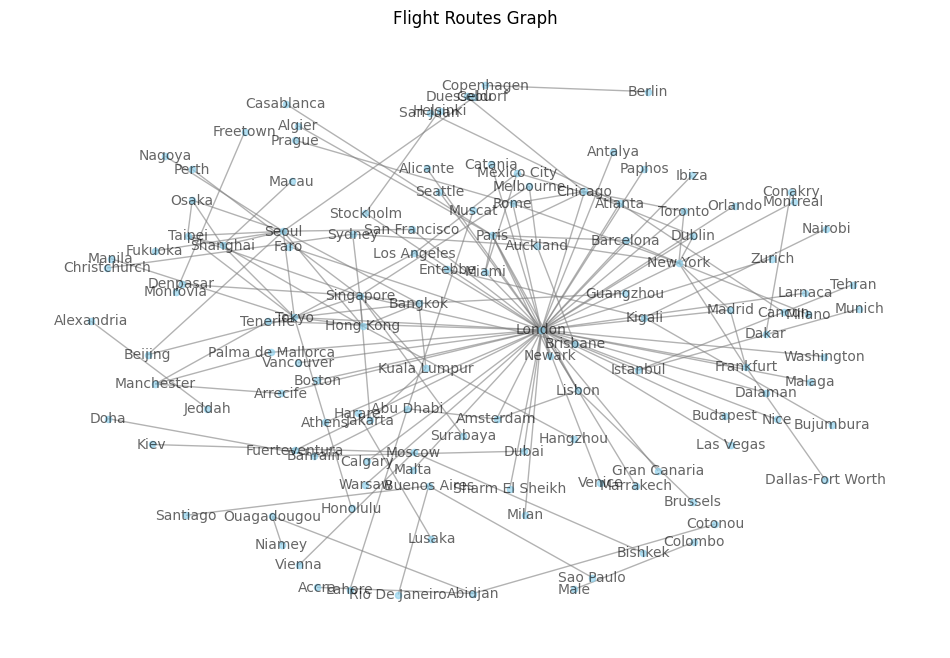

In [ ]:
G = nx.from_pandas_edgelist(int_routes_df.toPandas(), 'source_city', 'dest_city')

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx(G, pos, with_labels=True, node_size=20, font_size=10, node_color="skyblue", alpha=0.6, edge_color="gray")
plt.title("Flight Routes Graph")
plt.axis('off')
plt.show()

# Exercises

**Exercise 1**

What are the most common air routes?

Consider both directions, for example flights between **ATL** and **ORD** are sum of **ATL** -> **ORD** and **ORD** -> **ATL**.

In [ ]:
# prompt: solve exercise 1

from pyspark.sql.functions import col, when, concat_ws, count

# Create a combined column representing the route in both directions
routes_df1 = routes_df.withColumn("combined_route",
                                  when(col("source_airport") < col("destination_airport"),
                                       concat_ws("_", col("source_airport"), col("destination_airport")))
                                  .otherwise(concat_ws("_", col("destination_airport"), col("source_airport"))))

# Print schema and show data for debugging
routes_df1.printSchema()
routes_df1.show()

# Count the occurrences of each combined route
common_routes = routes_df1.groupBy("combined_route") \
                         .agg(count("*").alias("route_count")) \
                         .orderBy(col("route_count").desc())

# Show the most common routes
common_routes.show()


root
 |-- airline: string (nullable = true)
 |-- airline_id: string (nullable = true)
 |-- source_airport: string (nullable = true)
 |-- source_airport_id: string (nullable = true)
 |-- destination_airport: string (nullable = true)
 |-- destination_airport_id: string (nullable = true)
 |-- codeshare: string (nullable = true)
 |-- stops: integer (nullable = true)
 |-- equipment: string (nullable = true)
 |-- combined_route: string (nullable = false)

+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+--------------+
|airline|airline_id|source_airport|source_airport_id|destination_airport|destination_airport_id|codeshare|stops|equipment|combined_route|
+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+--------------+
|     2B|       410|           AER|             2965|                KZN|                  2990|     NULL|    0|      CR2|       AER

In [ ]:
pop_routes = """
SELECT
  CASE
    WHEN source_airport < destination_airport THEN source_airport || '-' || destination_airport
    ELSE destination_airport || '-' || source_airport
  END AS route,
  COUNT(*) AS num_flights
FROM routes
GROUP BY route
ORDER BY num_flights DESC
"""

pop_routes = spark.sql(pop_routes)
pop_routes.show()


+-------+-----------+
|  route|num_flights|
+-------+-----------+
|ATL-ORD|         39|
|BKK-HKG|         24|
|JFK-LHR|         24|
|ATL-MIA|         24|
|BKK-HKT|         23|
|AUH-MCT|         23|
|ATL-DEN|         22|
|BAH-DOH|         22|
|CDG-JFK|         22|
|JFK-MSY|         22|
|CAN-HGH|         22|
|LAX-LHR|         22|
|MSY-ORD|         21|
|ATL-DFW|         21|
|BKK-CNX|         21|
|AKL-SYD|         21|
|CGK-KUL|         20|
|ICN-NRT|         20|
|BKK-ICN|         20|
|CGO-HGH|         20|
+-------+-----------+
only showing top 20 rows



**Exercise 2**

Find out if any city have more than 1 airport. If so, find top 3.

In [ ]:
airports_count = """
SELECT city, count(1) as number_of_airports
FROM airports
GROUP BY city
ORDER BY number_of_airports DESC
"""

airports_count_df = spark.sql(airports_count)
airports_count_df.show()

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `airports` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 3 pos 5;
'Sort ['number_of_airports DESC NULLS LAST], true
+- 'Aggregate ['city], ['city, count(1) AS number_of_airports#1833L]
   +- 'UnresolvedRelation [airports], [], false


**Exercise 3**

Find number of inner connections for each country.

Plot connection graph between all countries.

In [ ]:
# prompt: solve exercise 3

# Exercise 3: Find the number of inner connections for each country and plot the connection graph.

inner_connections = routes_with_flight_type.filter(col("flight_type") == "Domestic") \
    .groupBy("source_country") \
    .agg(count("*").alias("num_inner_connections")) \
    .orderBy(col("num_inner_connections").desc())

inner_connections.show()

# Plotting the connection graph between countries
import matplotlib.pyplot as plt
import networkx as nx

country_connections = routes_with_flight_type.groupBy("source_country", "dest_country") \
    .agg(count("*").alias("num_flights")) \
    .filter(col("source_country") != col("dest_country"))  # Exclude domestic flights

country_connections_pd = country_connections.toPandas()

G = nx.from_pandas_edgelist(country_connections_pd, 'source_country', 'dest_country', edge_attr='num_flights')

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)  # Adjust k for better layout
nx.draw_networkx(G, pos, with_labels=True, node_size=30, font_size=8, node_color="skyblue", alpha=0.7, edge_color="gray", width=0.5)
plt.title("Country Connections Graph")
plt.axis('off')
plt.show()


In [ ]:
!env | grep JAVA_HOME